In [1]:
import random
import keras
import subprocess
import pickle
import keras_metrics as km
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Embedding, Dropout, LSTM, Activation, Conv1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = Tokenizer()

Using TensorFlow backend.


In [2]:
# Reads the file, generates y data, makes a zip out of each x & y and then shuffles them
def get_data(bot_file, gen_file):
    x_data = []
    with open(bot_file, 'r', errors='ignore') as file:
        for line in file:
            x_data.append(line)

    size = len(x_data)

    with open(gen_file, 'r', errors='ignore') as file:
        for line in file:
            x_data.append(line)

    y_data = [1] * size + [0] * size

    train_set = list(zip(x_data, y_data))
    random.shuffle(train_set)
    x, y = zip(*train_set)
    return np.array(x), np.array(y)

In [3]:
x, y = get_data('trv-bot.txt', 'trv-gen.txt')

In [4]:
x_test, y_test = get_data('test-bot.txt', 'test-gen.txt')

In [5]:
vec = TfidfVectorizer(max_features=100,
                      tokenizer=word_tokenize,
                      strip_accents='unicode',
                      lowercase =True,
                      analyzer='word',
                      token_pattern=r'\w+',
                      use_idf=True,
                      smooth_idf=True,
                      sublinear_tf=False, 
                      stop_words = 'english'
                     )
tfidf_mat = vec.fit_transform(x).toarray()
print(type(tfidf_mat),tfidf_mat.shape)

<class 'numpy.ndarray'> (639996, 100)


In [6]:
test_tfidf_mat = vec.transform(x_test).toarray()
print(type(test_tfidf_mat),test_tfidf_mat.shape)

<class 'numpy.ndarray'> (159996, 100)


In [7]:
model = Sequential()
model.add(Dense(512,input_shape=(100,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy',km.binary_precision(), km.binary_recall()]
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)  

In [8]:
history = model.fit(
    tfidf_mat,
    y,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_split=0.25
)

Instructions for updating:
Use tf.cast instead.
Train on 479997 samples, validate on 159999 samples
Epoch 1/20
479997/479997 [==============================] - 9s 19us/step - loss: 0.3236 - acc: 0.8511 - precision: 0.8931 - recall: 0.7976 - val_loss: 0.3021 - val_acc: 0.8635 - val_precision: 0.9153 - val_recall: 0.8013
Epoch 2/20
479997/479997 [==============================] - 8s 17us/step - loss: 0.3020 - acc: 0.8626 - precision: 0.9027 - recall: 0.8126 - val_loss: 0.2938 - val_acc: 0.8649 - val_precision: 0.8955 - val_recall: 0.8265
Epoch 3/20
479997/479997 [==============================] - 8s 17us/step - loss: 0.2954 - acc: 0.8657 - precision: 0.9096 - recall: 0.8121 - val_loss: 0.2915 - val_acc: 0.8673 - val_precision: 0.9106 - val_recall: 0.8149
Epoch 4/20
479997/479997 [==============================] - 8s 17us/step - loss: 0.2910 - acc: 0.8677 - precision: 0.9128 - recall: 0.8129 - val_loss: 0.2903 - val_acc: 0.8686 - val_precision: 0.9080 - val_recall: 0.8205
Epoch 5/20
47999

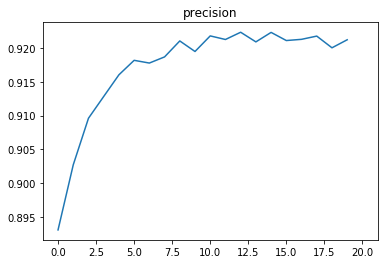

In [9]:
plt.xlim(left=-1, right=21)
plt.title('precision')
plt.plot(history.history['precision'], label='train')
plt.savefig('tfidf-c/precision.svg')

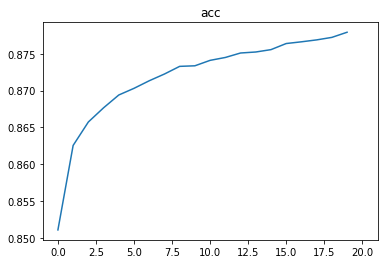

In [10]:
plt.xlim(left=-1, right=21)
plt.title('acc')
plt.plot(history.history['acc'], label='train')
plt.savefig('tfidf-c/accuracy.svg')

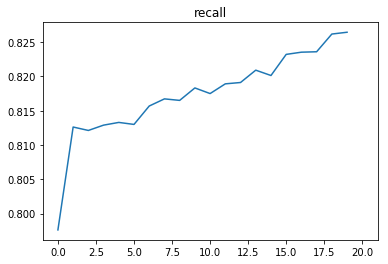

In [11]:
plt.xlim(left=-1, right=21)
plt.title('recall')
plt.plot(history.history['recall'], label='train')
plt.savefig('tfidf-c/recall.svg')

In [12]:
y_pred = model.predict(test_tfidf_mat).ravel()
fpr, tpr, threshold = roc_curve(y_test, y_pred)

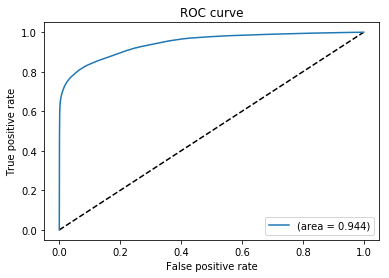

In [13]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(area = {:.3f})'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('tfidf-c/roc.svg')

In [14]:
score, acc, p, r = model.evaluate(test_tfidf_mat, y_test)
print('score:', score)
print('accuracy:', acc)
print('precision:', p)
print('recall:', r)

159996/159996 [==============================] - 3s 18us/step
score: 0.29231374976809266
accuracy: 0.8717905447665995
precision: 0.9118033921759615
recall: 0.823208080200976


In [15]:
model.save_weights("tfidf-c/model.h5")
print("Saved model to disk")

Saved model to disk
